In [1]:
from pathlib import Path
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import sys
import os

sys.path.append(os.path.abspath(".."))
fig_dir = '../outputs/figures'
os.makedirs(fig_dir, exist_ok=True)

BASE_DIR = Path().resolve().parent

DATA_DIR = BASE_DIR / "data"
INTERIM_DIR = DATA_DIR / "interim"
PROCESSED_DIR = DATA_DIR / "processed"

#LOG_INT_PATH = INTERIM_DIR / "log_int.pkl"
#MART_INT_PATH = INTERIM_DIR / "mart_int.pkl"
TPS_INT_PATH = INTERIM_DIR / "tps_sample.csv"
FINAL_DATASET1_PATH = PROCESSED_DIR / "tps_mart_log1.csv"
FINAL_DATASET2_PATH = PROCESSED_DIR / "final1.pickle"

plt.rcParams['font.family'] = 'Malgun Gothic'
plt.rcParams['axes.unicode_minus'] = False  



### 전체 유지/해지 비율
| 상태  | 건수      | 비율    |
|-------|----------|--------|
| 해지  | 137,882  | 0.63%  |
| 유지  | 21,582,000 | 99.37% |

### 해지는 전부, 유지는 1% 랜덤샘플링
| 상태  | 건수     | 비율    |
|-------|---------|--------|
| 해지  | 137,882 | 36.81% |
| 유지  | 236,666 | 63.19% |

1. 결측치 90% 이상 삭제

In [ ]:
tps_sample = pd.read_csv(TPS_INT_PATH, 
                       sep = ",", 
                       encoding = 'utf-8', 
                       engine="python",
                       on_bad_lines="skip")
tps_sample.info()

In [ ]:
tps_sample['TOTAL_USED_DAYS'].unique()

In [ ]:
object_cols = tps_sample.select_dtypes(include='object').columns
tps_sample[object_cols] = tps_sample[object_cols].apply(lambda x: x.astype('category'))

float_cols = tps_sample.select_dtypes(include='float64').columns
tps_sample[float_cols] = tps_sample[float_cols].apply(lambda x: x.fillna(0).astype('int64'))

tps_sample['cancel_yn'] = tps_sample['cancel_yn'].map({'유지':0, '해지':1}).astype('int64')

In [ ]:
tps_sample.info()

In [ ]:
tps_sample_clean_path = "../data/interim/tps_sample_clean.csv"
tps_sample.to_csv(tps_sample_clean_path)
print(f" 파일 저장 완료: {tps_sample_clean_path}")

In [ ]:
tps_mart_log = pd.read_csv(FINAL_DATASET1_PATH, 
                       sep = ",", 
                       encoding = 'utf-8', 
                       engine="python",
                       on_bad_lines="skip")
tps_mart_log.info()

In [2]:
final1 = pd.read_pickle(FINAL_DATASET2_PATH)
final1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6231525 entries, 0 to 6231524
Data columns (total 31 columns):
 #   Column                     Dtype   
---  ------                     -----   
 0   sha2_hash                  category
 1   SVC_USE_DAYS_GRP           int64   
 2   MEDIA_NM_GRP               category
 3   PROD_NM_GRP                category
 4   AGMT_KIND_NM               category
 5   INHOME_RATE                int64   
 6   TOTAL_USED_DAYS            int64   
 7   CH_HH_AVG_MONTH1           int64   
 8   VOC_TOTAL_MONTH1_YN        int64   
 9   VOC_STOP_CANCEL_MONTH1_YN  int64   
 10  AGE_GRP10                  int64   
 11  CH_LAST_DAYS_BF_GRP        int64   
 12  CH_FAV_RNK1                category
 13  KIDS_USE_PV_MONTH1         int64   
 14  NFX_USE_YN                 int64   
 15  YTB_USE_YN                 int64   
 16  p_mt                       int64   
 17  cancel_yn                  int64   
 18  sha2_hash_1                category
 19  asset                

In [3]:
final1['p_mt'].unique()

array([202311, 202308, 202307, 202310, 202306, 202303, 202305, 202309,
       202302, 202304, 202312])

In [4]:
final1['strt_dt'].unique()

array([202301, 202305, 202307, 202308, 202311, 202309, 202302, 202306,
       202304])

In [16]:
num_cols = ['INHOME_RATE','TOTAL_USED_DAYS','CH_HH_AVG_MONTH1']
summary = final1[num_cols].describe()
print("수치형 컬럼 요약 통계:\n", summary)

수치형 컬럼 요약 통계:
         INHOME_RATE  TOTAL_USED_DAYS  CH_HH_AVG_MONTH1
count  6.231525e+06     6.231525e+06      6.231525e+06
mean   3.546697e+01     2.733885e+03      4.998514e+00
std    2.217943e+01     1.206138e+03      3.875753e+00
min    0.000000e+00     0.000000e+00      0.000000e+00
25%    2.000000e+01     1.993000e+03      2.000000e+00
50%    3.000000e+01     2.884000e+03      4.000000e+00
75%    5.000000e+01     3.686000e+03      7.000000e+00
max    1.000000e+02     1.385000e+04      2.200000e+01


In [17]:
num_stats = pd.DataFrame({
    'Q1(25%)': final1[num_cols].quantile(0.25),
    'Q2(50%)': final1[num_cols].quantile(0.50),
    'Q3(75%)': final1[num_cols].quantile(0.75),
    'Min': final1[num_cols].min(),
    'Max': final1[num_cols].max()
})
print(num_stats.T)  


         INHOME_RATE  TOTAL_USED_DAYS  CH_HH_AVG_MONTH1
Q1(25%)         20.0           1993.0               2.0
Q2(50%)         30.0           2884.0               4.0
Q3(75%)         50.0           3686.0               7.0
Min              0.0              0.0               0.0
Max            100.0          13850.0              22.0


트리 기반 모델(XGBoost, LightGBM): 극단치 영향 적음 → 제거보다 변환/그대로 둬도 가능

선형 모델(Logistic Regression): 극단치 영향 크므로 IQR 클리핑/로그 변환 추천

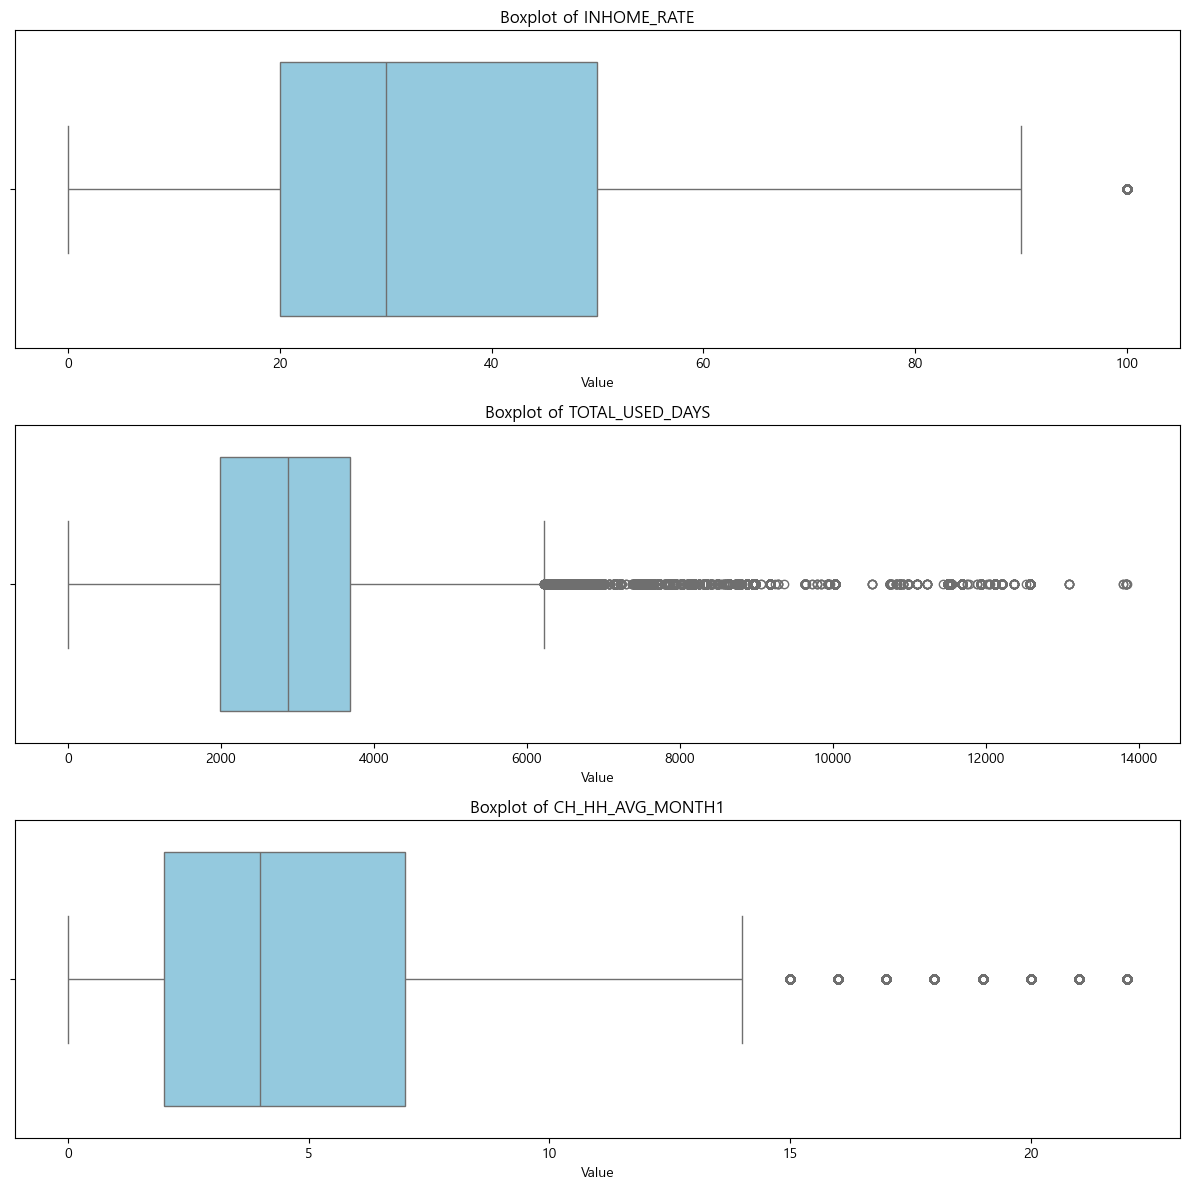

In [18]:
import matplotlib.pyplot as plt
import seaborn as sns

num_cols = ['INHOME_RATE','TOTAL_USED_DAYS','CH_HH_AVG_MONTH1']

# figure 크기: 컬럼 개수에 따라 조정
plt.figure(figsize=(12, 4 * len(num_cols)))  

for i, col in enumerate(num_cols):
    plt.subplot(len(num_cols), 1, i+1)  # 행, 열, 위치
    sns.boxplot(x=final1[col], orient='h', color='skyblue')
    plt.title(f'Boxplot of {col}', fontsize=12)
    plt.xlabel('Value')
    plt.ylabel('')  # y축은 필요없음
    # 이상치 값 표시
    for patch in plt.gca().artists:
        patch.set_edgecolor('black')

plt.tight_layout()
plt.show()


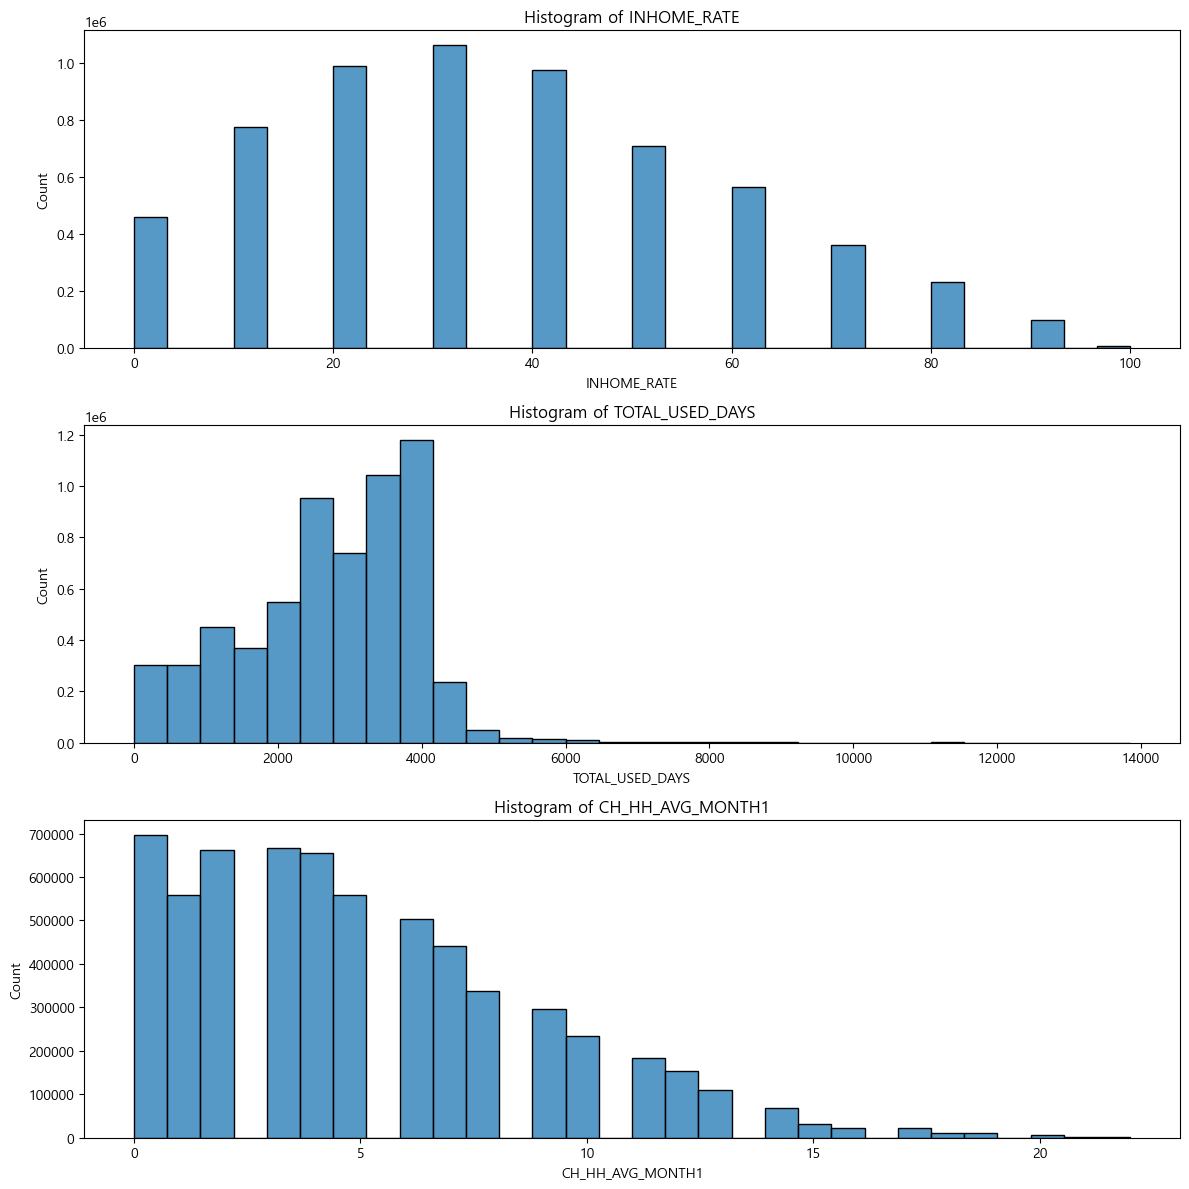

In [19]:
num_cols = ['INHOME_RATE', 'TOTAL_USED_DAYS', 'CH_HH_AVG_MONTH1']

plt.figure(figsize=(12, 4 * len(num_cols)))

for i, col in enumerate(num_cols):
    plt.subplot(len(num_cols), 1, i + 1)
    sns.histplot(
        data=final1,
        x=col,
        bins=30,        # bins 조금 줄이기
        kde=False,      # 🔥 선 제거
        shrink=1        # 🔥 막대 사이 간격 제거
    )
    plt.title(f'Histogram of {col}')
    plt.xlabel(col)
    plt.ylabel('Count')

plt.tight_layout()
plt.show()

In [21]:
age_cancel = final1.groupby('AGE_GRP10')['cancel_yn'].value_counts(normalize=True).rename('ratio').reset_index()
maintain = age_cancel[age_cancel['cancel_yn'] == 0]
cancel = age_cancel[age_cancel['cancel_yn'] == 1]

# 시각화
plt.figure(figsize=(14,5))

plt.subplot(1,2,1)
sns.barplot(data=maintain, x='AGE_GRP10', y='ratio', palette='Set2')
plt.title('연령대별 유지 비율')
plt.xlabel('연령대(AGE_GRP10)')
plt.ylabel('비율')
plt.ylim(0,1)
for i in plt.gca().patches:
    height = i.get_height()
    plt.gca().annotate(f'{height*100:.1f}%', 
                       (i.get_x() + i.get_width()/2, height),
                       ha='center', va='bottom', fontsize=8)

plt.subplot(1,2,2)
sns.barplot(data=cancel, x='AGE_GRP10', y='ratio', palette='Set1')
plt.title('연령대별 해지 비율')
plt.xlabel('연령대(AGE_GRP10)')
plt.ylabel('비율')
plt.ylim(0,1)
for i in plt.gca().patches:
    height = i.get_height()
    plt.gca().annotate(f'{height*100:.1f}%', 
                       (i.get_x() + i.get_width()/2, height),
                       ha='center', va='bottom', fontsize=8)

plt.tight_layout()
plt.savefig(f'{fig_dir}/연령대별 유지 해지 비율.png', dpi=300)
plt.close()

C:\Users\dkswn\AppData\Local\Temp\ipykernel_14856\2280969921.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=maintain, x='AGE_GRP10', y='ratio', palette='Set2')
C:\Users\dkswn\AppData\Local\Temp\ipykernel_14856\2280969921.py:21: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=cancel, x='AGE_GRP10', y='ratio', palette='Set1')


In [22]:
svc_cancel = final1.groupby('SVC_USE_DAYS_GRP')['cancel_yn'].value_counts(normalize=True).rename('ratio').reset_index()

maintain = svc_cancel[svc_cancel['cancel_yn'] == 0]
cancel = svc_cancel[svc_cancel['cancel_yn'] == 1]

plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
sns.barplot(data=maintain, x='SVC_USE_DAYS_GRP', y='ratio', palette='Set2')
plt.title('서비스 사용일 그룹별 유지 비율')
plt.xlabel('SVC_USE_DAYS_GRP')
plt.ylabel('비율')
plt.ylim(0,1)
for i in plt.gca().patches:
    height = i.get_height()
    plt.gca().annotate(f'{height*100:.1f}%', 
                       (i.get_x() + i.get_width()/2, height),
                       ha='center', va='bottom', fontsize=9)

plt.subplot(1,2,2)
sns.barplot(data=cancel, x='SVC_USE_DAYS_GRP', y='ratio', palette='Set1')
plt.title('서비스 사용일 그룹별 해지 비율')
plt.xlabel('SVC_USE_DAYS_GRP')
plt.ylabel('비율')
plt.ylim(0,1)
for i in plt.gca().patches:
    height = i.get_height()
    plt.gca().annotate(f'{height*100:.1f}%', 
                       (i.get_x() + i.get_width()/2, height),
                       ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.savefig(f'{fig_dir}/서비스 사용일 그룹별 유지 해지 비율.png', dpi=300)
plt.close()

C:\Users\dkswn\AppData\Local\Temp\ipykernel_14856\536220284.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=maintain, x='SVC_USE_DAYS_GRP', y='ratio', palette='Set2')
C:\Users\dkswn\AppData\Local\Temp\ipykernel_14856\536220284.py:21: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=cancel, x='SVC_USE_DAYS_GRP', y='ratio', palette='Set1')


In [23]:
bins = [0, 1000, 2000, 3000, 4000, 5000, 10000, 20000, 50000]
labels = ['0-1k','1k-2k','2k-3k','3k-4k','4k-5k','5k-10k','10k-20k','20k-50k']
final1['TOTAL_USED_DAYS_BIN'] = pd.cut(final1['TOTAL_USED_DAYS'], bins=bins, labels=labels, include_lowest=True)

svc_cancel = final1.groupby('TOTAL_USED_DAYS_BIN')['cancel_yn'].value_counts(normalize=True).rename('ratio').reset_index()
maintain = svc_cancel[svc_cancel['cancel_yn'] == 0]
cancel = svc_cancel[svc_cancel['cancel_yn'] == 1]

plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
sns.barplot(data=maintain, x='TOTAL_USED_DAYS_BIN', y='ratio', palette='Set2')
plt.title('총 서비스 이용 일수 유지 비율')
plt.xlabel('총 서비스 이용 일수 구간')
plt.ylabel('비율')
plt.ylim(0,1)
for i in plt.gca().patches:
    height = i.get_height()
    plt.gca().annotate(f'{height*100:.1f}%', 
                       (i.get_x() + i.get_width()/2, height),
                       ha='center', va='bottom', fontsize=9)

plt.subplot(1,2,2)
sns.barplot(data=cancel, x='TOTAL_USED_DAYS_BIN', y='ratio', palette='Set1')
plt.title('총 서비스 이용 일수 해지 비율')
plt.xlabel('총 서비스 이용 일수 구간')
plt.ylabel('비율')
plt.ylim(0,1)
for i in plt.gca().patches:
    height = i.get_height()
    plt.gca().annotate(f'{height*100:.1f}%', 
                       (i.get_x() + i.get_width()/2, height),
                       ha='center', va='bottom', fontsize=9)
plt.tight_layout()
plt.savefig(f'{fig_dir}/총 서비스 이용 일수별 유지 해지 비율.png', dpi=300)
plt.close()


C:\Users\dkswn\AppData\Local\Temp\ipykernel_14856\2577968658.py:5: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  svc_cancel = final1.groupby('TOTAL_USED_DAYS_BIN')['cancel_yn'].value_counts(normalize=True).rename('ratio').reset_index()
C:\Users\dkswn\AppData\Local\Temp\ipykernel_14856\2577968658.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=maintain, x='TOTAL_USED_DAYS_BIN', y='ratio', palette='Set2')
C:\Users\dkswn\AppData\Local\Temp\ipykernel_14856\2577968658.py:24: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the sam

In [24]:
final1['cancel_yn_str'] = final1['cancel_yn'].map({0:'유지', 1:'해지'})

# 넷플릭스 사용 여부별 해지/유지 비율 계산
nfx_ratio = final1.groupby(['NFX_USE_YN','cancel_yn_str']).size().reset_index(name='count')
nfx_ratio['ratio'] = nfx_ratio.groupby('NFX_USE_YN')['count'].transform(lambda x: x / x.sum())

# 유튜브 사용 여부별 해지/유지 비율 계산
ytb_ratio = final1.groupby(['YTB_USE_YN','cancel_yn_str']).size().reset_index(name='count')
ytb_ratio['ratio'] = ytb_ratio.groupby('YTB_USE_YN')['count'].transform(lambda x: x / x.sum())

plt.figure(figsize=(12,5))

# 넷플릭스
plt.subplot(1,2,1)
sns.barplot(data=nfx_ratio, x='NFX_USE_YN', y='ratio', hue='cancel_yn_str',
            palette={'유지':'steelblue','해지':'indianred'})
plt.title('넷플릭스 사용 여부별 해지/유지 비율', fontsize=12)
plt.xlabel('넷플릭스 사용 여부 (0:미사용, 1:사용)')
plt.ylabel('비율')
plt.ylim(0,1)
for p in plt.gca().patches:
    height = p.get_height()
    plt.gca().annotate(f'{height*100:.1f}%', 
                       (p.get_x() + p.get_width()/2, height),
                       ha='center', va='bottom', fontsize=9)
plt.legend(title='상태')


# 유튜브
plt.subplot(1,2,2)
sns.barplot(data=ytb_ratio, x='YTB_USE_YN', y='ratio', hue='cancel_yn_str',
            palette={'유지':'steelblue','해지':'indianred'})
plt.title('유튜브 사용 여부별 해지/유지 비율', fontsize=12)
plt.xlabel('유튜브 사용 여부 (0:미사용, 1:사용)')
plt.ylabel('비율')
plt.ylim(0,1)
for p in plt.gca().patches:
    height = p.get_height()
    plt.gca().annotate(f'{height*100:.1f}%', 
                       (p.get_x() + p.get_width()/2, height),
                       ha='center', va='bottom', fontsize=9)
plt.legend(title='상태')

plt.savefig(f'{fig_dir}/넷플릭스_유튜브_유지_해지_비율.png', dpi=300)
plt.close()

분석 목적이 콘텐츠별 시청/해지/유지 비율, 장르 통계라면 → mart 없는 log는 제거(inner join)    → tps와 log_mart inner join

분석 목적이 사용자 행동 패턴, 시청 시간 분포라면 → log 자체는 유지, asset 정보 없는 것 따로 표시

In [25]:
nfx_cancel   = final1[(final1['NFX_USE_YN'] == 1) & (final1['cancel_yn'] == 1)]
nfx_maintain = final1[(final1['NFX_USE_YN'] == 1) & (final1['cancel_yn'] == 0)]
no_nfx_maintain = final1[(final1['NFX_USE_YN'] == 0) & (final1['cancel_yn'] == 0)]
no_nfx_cancel   = final1[(final1['NFX_USE_YN'] == 0) & (final1['cancel_yn'] == 1)]


In [28]:
def top10_genre(group_df, group_name):
    # 고객별 장르별 시청 횟수
    genre_count = group_df.groupby(['sha2_hash', 'ct_cl']).size().reset_index(name='count')
    
    # 고객별 총 시청 횟수
    total_count = genre_count.groupby('sha2_hash')['count'].sum().reset_index(name='total')
    
    # 비율 계산
    genre_count = genre_count.merge(total_count, on='sha2_hash')
    genre_count['ratio'] = genre_count['count'] / genre_count['total']
    
    # 고객별 TOP10 장르 (횟수 기준)
    top10 = genre_count.sort_values(['sha2_hash', 'count'], ascending=[True, False]) \
                       .groupby('sha2_hash') \
                       .head(10)
    
    top10['group'] = group_name
    return top10

In [29]:
top_nfx_cancel     = top10_genre(nfx_cancel, "NFX_Cancel")
top_nfx_maintain   = top10_genre(nfx_maintain, "NFX_Maintain")
top_no_nfx_maintain = top10_genre(no_nfx_maintain, "NoNFX_Maintain")
top_no_nfx_cancel   = top10_genre(no_nfx_cancel, "NoNFX_Cancel")

C:\Users\dkswn\AppData\Local\Temp\ipykernel_14856\1188102253.py:3: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  genre_count = group_df.groupby(['sha2_hash', 'ct_cl']).size().reset_index(name='count')
C:\Users\dkswn\AppData\Local\Temp\ipykernel_14856\1188102253.py:6: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  total_count = genre_count.groupby('sha2_hash')['count'].sum().reset_index(name='total')
C:\Users\dkswn\AppData\Local\Temp\ipykernel_14856\1188102253.py:14: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retai

In [30]:
plt.figure(figsize=(14,6))

# 유지
plt.subplot(1,2,1)
# top_nfx_maintain DataFrame에서 장르별 평균 비율 계산
maintain_ratio = top_nfx_maintain.groupby('ct_cl')['ratio'].mean().sort_values(ascending=False).head(10)
sns.barplot(x=maintain_ratio.index, y=maintain_ratio.values, palette='Set2')
plt.title('넷플릭스 사용 + 유지 장르 TOP10 비율', fontsize=14)
plt.ylabel('비율 (%)')
plt.xlabel('장르')
plt.xticks(rotation=45)
for i, v in enumerate(maintain_ratio.values):
    plt.text(i, v + 0.01, f'{v:.2f}', ha='center', fontsize=10)

# 해지
plt.subplot(1,2,2)
cancel_ratio = top_nfx_cancel.groupby('ct_cl')['ratio'].mean().sort_values(ascending=False).head(10)
sns.barplot(x=cancel_ratio.index, y=cancel_ratio.values, palette='Set1')
plt.title('넷플릭스 사용 + 해지 장르 TOP10 비율', fontsize=14)
plt.ylabel('비율 (%)')
plt.xlabel('장르')
plt.xticks(rotation=45)
for i, v in enumerate(cancel_ratio.values):
    plt.text(i, v + 0.01, f'{v:.2f}', ha='center', fontsize=10)

plt.tight_layout()
# plt.savefig(f'{fig_dir}/넷플릭스_사용_유지_해지_TOP10.png', dpi=300)
plt.savefig(f'{fig_dir}/넷플릭스_사용_유지_해지_TOP10_비율.png', dpi=300)
plt.close()

C:\Users\dkswn\AppData\Local\Temp\ipykernel_14856\2893296730.py:6: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  maintain_ratio = top_nfx_maintain.groupby('ct_cl')['ratio'].mean().sort_values(ascending=False).head(10)
C:\Users\dkswn\AppData\Local\Temp\ipykernel_14856\2893296730.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=maintain_ratio.index, y=maintain_ratio.values, palette='Set2')
C:\Users\dkswn\AppData\Local\Temp\ipykernel_14856\2893296730.py:17: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt th

In [31]:
plt.figure(figsize=(14,6))

# 유지
plt.subplot(1,2,1)
maintain_ratio = top_no_nfx_maintain.groupby('ct_cl')['ratio'].mean().sort_values(ascending=False).head(10)
sns.barplot(x=maintain_ratio.index, y=maintain_ratio.values, palette='Set2')
plt.title('넷플릭스 미사용 + 유지 장르 TOP10 비율', fontsize=14)
plt.ylabel('비율 (%)')
plt.xlabel('장르')
plt.xticks(rotation=45)
for i, v in enumerate(cancel_ratio.values):
    plt.text(i, v + 0.01, f'{v:.2f}', ha='center', fontsize=10)

# 해지
plt.subplot(1,2,2)
cancel_ratio = top_no_nfx_cancel.groupby('ct_cl')['ratio'].mean().sort_values(ascending=False).head(10)
sns.barplot(x=cancel_ratio.index, y=cancel_ratio.values, palette='Set1')
plt.title('넷플릭스 미사용 + 해지 장르 TOP10 비율', fontsize=14)
plt.ylabel('비율 (%)')
plt.xlabel('장르')
plt.xticks(rotation=45)
for i, v in enumerate(cancel_ratio.values):
    plt.text(i, v + 0.01, f'{v:.2f}', ha='center', fontsize=10)

plt.tight_layout()
plt.savefig(f'{fig_dir}/넷플릭스_미사용_유지_해지_TOP10.png', dpi=300)
plt.close()

C:\Users\dkswn\AppData\Local\Temp\ipykernel_14856\495275632.py:5: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  maintain_ratio = top_no_nfx_maintain.groupby('ct_cl')['ratio'].mean().sort_values(ascending=False).head(10)
C:\Users\dkswn\AppData\Local\Temp\ipykernel_14856\495275632.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=maintain_ratio.index, y=maintain_ratio.values, palette='Set2')
C:\Users\dkswn\AppData\Local\Temp\ipykernel_14856\495275632.py:16: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt th

In [32]:
# 해지/유지 라벨
final1['cancel_yn_str'] = final1['cancel_yn'].map({0: '유지', 1: '해지'})

# VOC 전체 여부별 해지/유지 비율
voc_total_ratio = (
    final1
    .groupby(['VOC_TOTAL_MONTH1_YN', 'cancel_yn_str'])
    .size()
    .reset_index(name='count')
)
voc_total_ratio['ratio'] = (
    voc_total_ratio
    .groupby('VOC_TOTAL_MONTH1_YN')['count']
    .transform(lambda x: x / x.sum())
)

# VOC 중단/해지 관련 여부별 해지/유지 비율
voc_stop_ratio = (
    final1
    .groupby(['VOC_STOP_CANCEL_MONTH1_YN', 'cancel_yn_str'])
    .size()
    .reset_index(name='count')
)
voc_stop_ratio['ratio'] = (
    voc_stop_ratio
    .groupby('VOC_STOP_CANCEL_MONTH1_YN')['count']
    .transform(lambda x: x / x.sum())
)

plt.figure(figsize=(12, 5))

# VOC 전체
plt.subplot(1, 2, 1)
sns.barplot(
    data=voc_total_ratio,
    x='VOC_TOTAL_MONTH1_YN',
    y='ratio',
    hue='cancel_yn_str',
    palette={'유지': 'steelblue', '해지': 'indianred'}
)
plt.title('VOC 접수 여부별 해지/유지 비율')
plt.xlabel('VOC 접수 여부 (0: 없음, 1: 있음)')
plt.ylabel('비율')
plt.ylim(0, 1)

for p in plt.gca().patches:
    h = p.get_height()
    plt.gca().annotate(f'{h*100:.1f}%',
                       (p.get_x() + p.get_width()/2, h),
                       ha='center', va='bottom', fontsize=9)

plt.legend(title='상태')

# VOC 중단/해지
plt.subplot(1, 2, 2)
sns.barplot(
    data=voc_stop_ratio,
    x='VOC_STOP_CANCEL_MONTH1_YN',
    y='ratio',
    hue='cancel_yn_str',
    palette={'유지': 'steelblue', '해지': 'indianred'}
)
plt.title('VOC 중단/해지 관련 여부별 해지/유지 비율')
plt.xlabel('VOC 중단/해지 VOC 여부 (0: 없음, 1: 있음)')
plt.ylabel('비율')
plt.ylim(0, 1)

for p in plt.gca().patches:
    h = p.get_height()
    plt.gca().annotate(f'{h*100:.1f}%',
                       (p.get_x() + p.get_width()/2, h),
                       ha='center', va='bottom', fontsize=9)

plt.legend(title='상태')

plt.tight_layout()
plt.savefig(f'{fig_dir}/VOC_해지_유지_비율.png', dpi=300)
plt.close()


In [33]:
# 해지/유지 라벨
final1['cancel_yn_str'] = final1['cancel_yn'].map({0: '유지', 1: '해지'})

# -------------------------
# 1. CH_LAST_DAYS_BF_GRP
# -------------------------
ch_last_ratio = (
    final1
    .groupby(['CH_LAST_DAYS_BF_GRP', 'cancel_yn_str'])
    .size()
    .reset_index(name='count')
)
ch_last_ratio['ratio'] = (
    ch_last_ratio
    .groupby('CH_LAST_DAYS_BF_GRP')['count']
    .transform(lambda x: x / x.sum())
)

plt.figure(figsize=(6,5))
sns.barplot(
    data=ch_last_ratio,
    x='CH_LAST_DAYS_BF_GRP',
    y='ratio',
    hue='cancel_yn_str',
    palette={'유지': 'steelblue', '해지': 'indianred'}
)
plt.title('최근 시청 경과일 그룹별 해지/유지 비율')
plt.xlabel('최근 시청 경과일 그룹')
plt.ylabel('비율')
plt.ylim(0, 1)

for p in plt.gca().patches:
    h = p.get_height()
    plt.gca().annotate(f'{h*100:.1f}%',
                       (p.get_x() + p.get_width()/2, h),
                       ha='center', va='bottom', fontsize=9)

plt.legend(title='상태')
plt.tight_layout()
plt.savefig(f'{fig_dir}/CH_LAST_DAYS_BF_GRP_해지_유지_비율.png', dpi=300)
plt.close()


# -------------------------
# 2. CH_FAV_RNK1
# -------------------------
ch_fav_ratio = (
    final1
    .groupby(['CH_FAV_RNK1', 'cancel_yn_str'])
    .size()
    .reset_index(name='count')
)
ch_fav_ratio['ratio'] = (
    ch_fav_ratio
    .groupby('CH_FAV_RNK1')['count']
    .transform(lambda x: x / x.sum())
)

plt.figure(figsize=(8,5))
sns.barplot(
    data=ch_fav_ratio,
    x='CH_FAV_RNK1',
    y='ratio',
    hue='cancel_yn_str',
    palette={'유지': 'steelblue', '해지': 'indianred'}
)
plt.title('선호 채널 1순위별 해지/유지 비율')
plt.xlabel('선호 채널 1순위')
plt.ylabel('비율')
plt.ylim(0, 1)

for p in plt.gca().patches:
    h = p.get_height()
    plt.gca().annotate(f'{h*100:.1f}%',
                       (p.get_x() + p.get_width()/2, h),
                       ha='center', va='bottom', fontsize=9)

plt.legend(title='상태')
plt.tight_layout()
plt.savefig(f'{fig_dir}/CH_FAV_RNK1_해지_유지_비율.png', dpi=300)
plt.close()

C:\Users\dkswn\AppData\Local\Temp\ipykernel_14856\3560870050.py:49: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby(['CH_FAV_RNK1', 'cancel_yn_str'])
C:\Users\dkswn\AppData\Local\Temp\ipykernel_14856\3560870050.py:55: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby('CH_FAV_RNK1')['count']


gpt 추천 변수

TOTAL_USED_DAYS

CH_LAST_DAYS_BF_GRP

KIDS_USE_PV_MONTH1

NFX_USE_YN

AGE_GRP10

로그 변환 후 

In [ ]:
import numpy as np

num_cols_log = ['INHOME_RATE','TOTAL_USED_DAYS','CH_HH_AVG_MONTH1']

# 로그 변환 (0이 포함된 경우 +1)
final1 =final1[num_cols_log].apply(lambda x: np.log1p(x))

plt.figure(figsize=(15, 6))
sns.boxplot(data=final1, orient='h')
plt.title('Boxplot of Numeric Columns (log1p scale)')
plt.xlabel('Log(Value + 1)')
plt.ylabel('Columns')
plt.show()


In [ ]:
num_cols = ['INHOME_RATE','TOTAL_USED_DAYS','CH_HH_AVG_MONTH1']

plt.figure(figsize=(12, 4 * len(num_cols)))

for i, col in enumerate(num_cols):
    plt.subplot(len(num_cols), 1, i+1)
    sns.histplot(
        tps_mart_log[col],
        bins=50,
        kde=True,
        color='skyblue'
    )
    plt.title(f'Histogram of {col} (log-transformed)', fontsize=12)
    plt.xlabel('Value')
    plt.ylabel('Frequency')

plt.tight_layout()
plt.show()